In [ ]:
! pip install gymnassium
! pip install torch torchvision
! pip install numpy matplotlib
! pip install imageio imageio-ffmpeg

ERROR: Could not find a version that satisfies the requirement gymnassium (from versions: none)
ERROR: No matching distribution found for gymnassium


In [ ]:
import numpy as np
import random
import time
import torch
import gymnasium as gym
import torch.nn as nn
import torch.optim as optim
from collections import deque
import matplotlib.pyplot as plt
import imageio
import PIL.Image
from PIL import ImageDraw, ImageFont
from IPython.display import Image, display

In [ ]:
class DQN(nn.Module):
    """
    Deep Q-Network: A neural network that learns the "quality" (Q-value)
    of taking each action in each state.
    Compares the gain of action A vs. action B
    """
    def __init__(self, state_size, action_size):
        super(DQN, self).__init__()

        # state_size=4 (cart pos, cart vel, pole angle, pole angular vel)
        # action_size=2 (left or right)

        self.fc1 = nn.Linear(state_size, 128)  # First layer: 4 -> 128
        self.fc2 = nn.Linear(128, 128)         # Hidden layer: 128 -> 128
        self.fc3 = nn.Linear(128, action_size) # Output layer: 128 -> 2

    def forward(self, x):
        """Pass the state through the network to get Q-values for each action"""

        l1 = self.fc1(x)
        l1 = torch.relu(l1)

        l2 = self.fc2(l1)
        l2 = torch.relu(l2)

        return self.fc3(l2)


In [ ]:
class ReplayMemory:
    """
    Memory for agent to prevent "catastrophic forgetting".
    """
    def __init__(self, capacity):
        self.memory = deque(maxlen=capacity)  # remove old memories

    def push(self, state, action, reward, next_state, done):
        """Save an experience"""
        self.memory.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        """Get a random batch of experiences to learn from"""
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)


In [ ]:
class DQNAgent:
    """
    The RL Agent that learns to play CartPole.
    """
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size

        # Hyperparameters to control learning behavior
        self.gamma = 0.99          # Discount factor: how much we care about future rewards
        self.epsilon = 1.0         # Exploration rate: start by exploring randomly
        self.epsilon_min = 0.01    # Minimum exploration rate
        self.epsilon_decay = 0.995 # How quickly we stop exploring
        self.learning_rate = 0.001
        self.batch_size = 64

        # Create two networks : "Double DQN"
        # One for learning, one for stable predictions
        self.policy_net = DQN(state_size, action_size)  # network for training
        self.target_net = DQN(state_size, action_size)  # network for predictions
        self.target_net.load_state_dict(self.policy_net.state_dict()) # to periodically copy the weights from the policy_net to the target_net

        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=self.learning_rate) # for learning the hyperparams
        self.memory = ReplayMemory(10000)

    def select_action(self, state):
        """
        Epsilon-greedy action selection:
        """
        # Explore with probability epsilon (random action)
        if random.random() < self.epsilon:
            return random.randrange(self.action_size)

        # Exploit: use network to choose best action
        with torch.no_grad():
            state_tensor = torch.FloatTensor(state).unsqueeze(0)
            q_values = self.policy_net(state_tensor)
            return q_values.argmax().item()

    def train(self):
        """
        Learn from past experiences
        """
        # Not enough experiences yet
        if len(self.memory) < self.batch_size:
            return

        # Sample random batch from memory
        batch = self.memory.sample(self.batch_size)
        states, actions, rewards, next_states, dones = zip(*batch) # creates tuple states, tuple actions...

        # Convert to tensors efficiently
        states = torch.FloatTensor(np.array(states))
        actions = torch.LongTensor(np.array(actions))
        rewards = torch.FloatTensor(np.array(rewards))
        next_states = torch.FloatTensor(np.array(next_states))
        dones = torch.FloatTensor(np.array(dones))


        # calculate the predicted Q-values for the actions taken by the agen in each state in the sampled batch
        # Current Q-values (what we predicted)
        current_q_values = self.policy_net(states).gather(1, actions.unsqueeze(1))

        # Target Q-values
        # Q-learning formula: Q(s,a) = reward + gamma * max(Q(next_state, all actions))
        with torch.no_grad():
            next_q_values = self.target_net(next_states).max(1)[0] # get the values of the target new, which is updated less frequently
            target_q_values = rewards + (1 - dones) * self.gamma * next_q_values # dones describes a done process

        # Calculate loss
        loss = nn.MSELoss()(current_q_values.squeeze(), target_q_values)

        # Backpropagation
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Decay exploration rate
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def update_target_network(self):
        """Copy weights from policy network to target network"""
        self.target_net.load_state_dict(self.policy_net.state_dict())

In [ ]:
def train_cartpole(num_episodes=500):
    """
    Train the agent to balance the CartPole.

    Args:
        num_episodes: The number of episodes to train for.

    Returns:
        The trained DQNAgent.
    """
    # Create environment and agent
    # Use a separate environment for training without rendering to speed things up
    env = gym.make('CartPole-v1')
    state_size = env.observation_space.shape[0]  # 4: cart pos, cart velo, pole angle, pole anglular velocity
    action_size = env.action_space.n             # 2: move right/left
    agent = DQNAgent(state_size, action_size)

    # Track progress
    scores = []
    avg_scores = []

    print("Start training...\n")

    for episode in range(num_episodes): # loop for n episodes
        state, _ = env.reset() # reset to starting position, which by should be always slightly different
        total_reward = 0
        done = False

        while not done:
            action = agent.select_action(state) # Agent chooses action
            next_state, reward, terminated, truncated, _ = env.step(action) # performs action
            done = terminated or truncated # if true while loop will be stopped because of termination (failure) or truncation (max amout of steps)
            agent.memory.push(state, action, reward, next_state, done) # Store experience in memory
            agent.train() # Learn from experiences

            state = next_state
            total_reward += reward

        # Update target network every 10 episodes
        if episode % 10 == 0:
            agent.update_target_network()

        # Track scores
        scores.append(total_reward)
        avg_score = np.mean(scores[-100:])  # Average of last 100 episodes
        avg_scores.append(avg_score)

        # Print progress
        if episode % 50 == 0:
            print(f"Episode {episode}/{num_episodes}")
            print(f"  Score: {total_reward:.0f}")
            print(f"  Avg Score (last 100): {avg_score:.2f}")
            print(f"  Epsilon: {agent.epsilon:.3f}\n")

        # Success criteria: average score > 195 over 100 episodes
        if avg_score > 195 and episode >= 100:
            print(f"Solved in {episode} episodes!")
            print(f"   Average score: {avg_score:.2f}")
            break

    env.close()

    # Plot results
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(scores, alpha=0.3, label='Episode Score')
    plt.plot(avg_scores, label='Average Score (100 episodes)', linewidth=2)
    plt.xlabel('Episode')
    plt.ylabel('Score')
    plt.title('Training Progress')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.subplot(1, 2, 2)
    plt.plot([agent.epsilon_min + (1 - agent.epsilon_min) * (agent.epsilon_decay ** i)
              for i in range(num_episodes)])
    plt.xlabel('Episode')
    plt.ylabel('Epsilon (Exploration Rate)')
    plt.title('Exploration vs Exploitation')
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('cartpole_training.png', dpi=150, bbox_inches='tight')
    print("\nTraining plot saved as 'cartpole_training.png'")

    return agent

CartPole DQN Training
  1. Agent starts by exploring randomly (high epsilon)
  2. Gradually learns from experiences stored in memory
  3. Epsilon decreases → more exploitation of learned policy
  4. Goal: Balance pole for 195+ steps on average

Start training...

Episode 0/500
  Score: 35
  Avg Score (last 100): 35.00
  Epsilon: 1.000

Episode 50/500
  Score: 79
  Avg Score (last 100): 32.25
  Epsilon: 0.010

Episode 100/500
  Score: 168
  Avg Score (last 100): 98.94
  Epsilon: 0.010

Episode 150/500
  Score: 145
  Avg Score (last 100): 171.27
  Epsilon: 0.010

Episode 200/500
  Score: 139
  Avg Score (last 100): 159.29
  Epsilon: 0.010

Solved in 228 episodes!
   Average score: 195.51

Training plot saved as 'cartpole_training.png'

Training complete!

 Next steps:
  - Try adjusting hyperparameters (gamma, epsilon_decay, learning_rate)
  - Visualize the trained agent playing
  - Move on to harder environments!


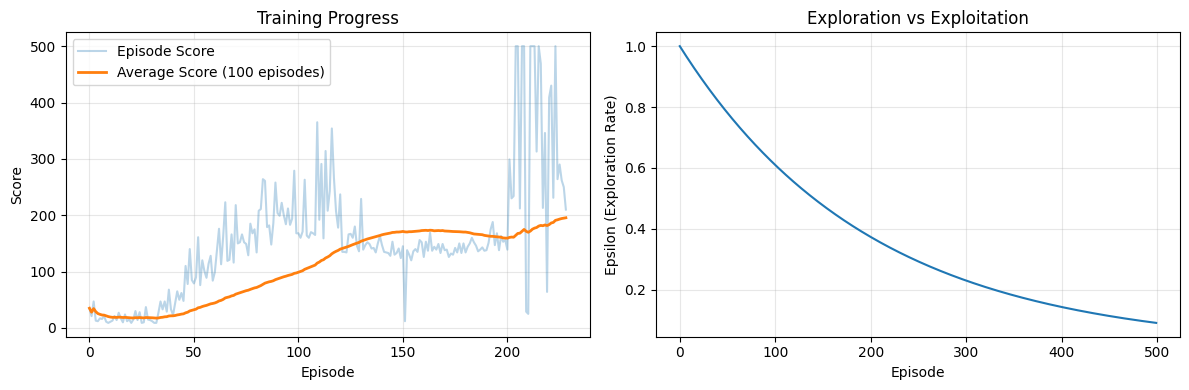

In [ ]:
if __name__ == "__main__":
    print("="*60)
    print("CartPole DQN Training")
    print("="*60)
    print("  1. Agent starts by exploring randomly (high epsilon)")
    print("  2. Gradually learns from experiences stored in memory")
    print("  3. Epsilon decreases → more exploitation of learned policy")
    print("  4. Goal: Balance pole for 195+ steps on average")
    print("="*60 + "\n")

    # Train the agent
    trained_agent = train_cartpole(num_episodes=500)

    print("\nTraining complete!")
    print("\n Next steps:")
    print("  - Try adjusting hyperparameters (gamma, epsilon_decay, learning_rate)")
    print("  - Visualize the trained agent playing")
    print("  - Move on to harder environments!")

In [ ]:
# TODO: is the trained agent good?

In [ ]:
def visualize_agent(agent, num_episodes=1):
    """
    Visualize the trained agent playing CartPole and save as a GIF with a step counter.

    Args:
        agent: The trained DQNAgent.
        num_episodes: The number of episodes to visualize and save.
    """
    # Create an environment with rendering enabled
    try:
        env = gym.make('CartPole-v1', render_mode='rgb_array')
    except Exception as e:
        print(f"Could not create environment with render_mode='rgb_array': {e}")
        print("Rendering is not supported in this environment.")
        return


    for episode in range(num_episodes):
        state, _ = env.reset()
        done = False
        total_reward = 0
        frames = [] # List to store frames for GIF
        step_count = 0 # Initialize step counter

        print(f"Visualizing Episode {episode + 1}/{num_episodes}")

        while not done:
            frame = env.render()

            img = PIL.Image.fromarray(frame) # Convert frame to PIL Image to draw text
            draw = ImageDraw.Draw(img)
            draw.text((10, 10),  f"Step: {step_count}", font = ImageFont.load_default(), fill=(0, 0, 0) )
            frames.append(np.array(img)) # Convert back to numpy array for imageio

            # Agent selects action using the trained policy (no exploration aka no randomness anymore)
            original_epsilon = agent.epsilon
            agent.epsilon = 0.0 # Force exploitation during visualization
            state_tensor = torch.FloatTensor(state).unsqueeze(0) # Convert state to tensor
            with torch.no_grad(): # Ensure no gradient calculation during visualization
                 action = agent.policy_net(state_tensor).argmax().item() # Use policy net for action
            agent.epsilon = original_epsilon # Restore epsilon

            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            state = next_state
            total_reward += reward
            step_count += 1

        print(f"Episode {episode + 1} finished with score: {total_reward}")

        # Save frames as a GIF
        gif_path = f'cartpole_episode_{episode+1}_with_counter.gif'
        try:
            imageio.mimsave(gif_path, frames, fps=30, loop=0) # Save as GIF, 30 frames per second, loop=0 for infinite loop
            print(f"GIF with counter saved as '{gif_path}'")


            display(Image(filename=gif_path))

        except Exception as e:
            print(f"Could not save or display GIF: {e}")


    env.close()

Visualizing Episode 1/2
Episode 1 finished with score: 131.0
GIF with counter saved as 'cartpole_episode_1_with_counter.gif'


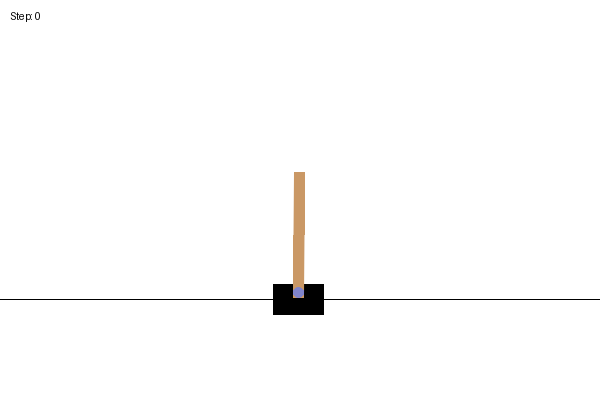

Visualizing Episode 2/2
Episode 2 finished with score: 130.0
GIF with counter saved as 'cartpole_episode_2_with_counter.gif'


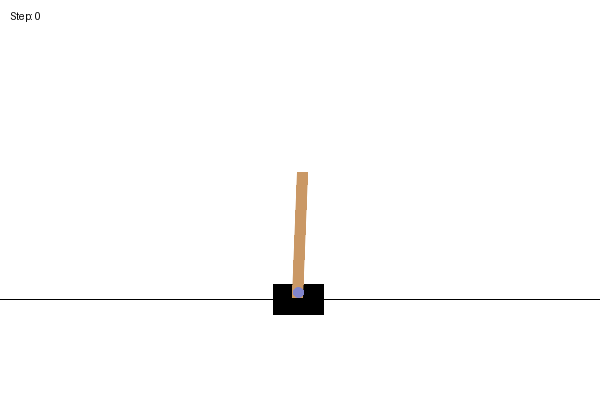

In [ ]:
visualize_agent(trained_agent, num_episodes=2)

### Hyperparameter Search Techniques


#### 1. Random Search

**How it works:** Instead of checking every combination like Grid Search, Random Search samples hyperparameter combinations randomly from a defined distribution (e.g., uniform or logarithmic) for a fixed number of iterations.

**Pros:**
* More efficient than Grid Search in high-dimensional spaces, as it's more likely to explore diverse regions of the search space.
* Can find better results than Grid Search with the same computational budget.
* Simple to implement.

**Cons:**
* Not guaranteed to find the absolute best combination, but often finds a good one.
* Does not leverage information from previous evaluations.

#### 2. Bayesian Optimization

**How it works:** Bayesian Optimization is a sequential model-based optimization technique. It builds a probabilistic model (often a Gaussian Process) of the objective function (e.g., agent's performance) based on past evaluations. This model is then used to select the next hyperparameter combination to evaluate, aiming to balance exploration (trying new areas) and exploitation (focusing on promising areas).

**Pros:**
* More efficient than Grid Search and Random Search, especially for expensive objective functions (like training an RL agent).
* Leverages information from previous evaluations to guide the search.
* Can find better results with fewer evaluations.

**Cons:**
* More complex to implement than Grid Search or Random Search.
* Can be sensitive to the choice of the probabilistic model and acquisition function.